In [5]:
import pandas as pd
import sys
import os
import importlib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Configurar el path para poder importar tools
# El notebook está en ENTREGABLES/marcos/, necesitamos subir un nivel a ENTREGABLES/
current_dir = os.getcwd()
# Si estamos en marcos/, subir un nivel
if current_dir.endswith('marcos'):
    entregables_dir = os.path.dirname(current_dir)
else:
    # Si no, buscar el directorio ENTREGABLES en el path actual
    entregables_dir = current_dir
    while not os.path.exists(os.path.join(entregables_dir, 'tools.py')):
        parent = os.path.dirname(entregables_dir)
        if parent == entregables_dir:  # Llegamos a la raíz
            break
        entregables_dir = parent

if os.path.exists(os.path.join(entregables_dir, 'tools.py')):
    if entregables_dir not in sys.path:
        sys.path.insert(0, entregables_dir)
    print(f"✅ Path configurado: {entregables_dir}")
else:
    print("⚠️ No se encontró el archivo tools.py. Verifica la estructura del proyecto.")

# Importar y recargar el módulo tools para asegurar que tenemos la versión más reciente
import tools
importlib.reload(tools)  # Recargar el módulo para obtener los cambios más recientes
from tools import (
    seleccionar_variables, 
    plot_costo_interactivo, 
    evaluate_model_with_thresholds, 
    evaluate_model,
    optimizar_threshold_costo_cv,
    optimizar_threshold_f1_cv
)

print("✅ Módulo tools recargado e importado correctamente")



✅ Path configurado: c:\Users\marca\OneDrive\AUSTRAL\2do año\2do cuat\TRP II\mercado-libre-fraude-2025\ENTREGABLES
✅ Módulo tools recargado e importado correctamente


In [6]:
df = pd.read_csv("../../DATA/processed/fraud_dataset_processed.csv")

df = seleccionar_variables(
    df,
    categoria_encoding=True, 
    pais_encoding=True,
    o_dummies=True,
    producto_nombre_encoding=True,
    fecha_encoding=3,
    usar_imputadas=True,
    remove_r = True,
    remove_d=True,
    remove_score=True
    )

Columnas reemplazadas por versiones imputadas: b, c, f, l, m, q


In [7]:
# ============================================================================
# PIPELINE COMPLETO DEL MODELO
# ============================================================================
# 1. Preparar datos
# 2. Entrenar modelos (uno con CV para optimizar thresholds, otro con todos los datos)
# 3. Optimizar thresholds (costo y F1) con CV
# 4. Evaluar modelo con ambos thresholds
# ============================================================================

# Preparar variables predictoras y target
X = df.drop(columns=['fraude'])
y = df['fraude']

# Split en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("=" * 80)
print("PASO 1: ENTRENAR MODELOS")
print("=" * 80)

# Mostrar distribución original
print(f"\n📊 Distribución del conjunto de entrenamiento:")
print(f"   - Clase 0 (No Fraude): {(y_train == 0).sum():,} ({(y_train == 0).mean()*100:.2f}%)")
print(f"   - Clase 1 (Fraude):    {(y_train == 1).sum():,} ({(y_train == 1).mean()*100:.2f}%)")

# Configurar Random Forest
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

# Crear Pipeline con SMOTE + Random Forest para CV
# SMOTE se aplicará dentro de cada fold del CV (evita data leakage)
print("\n🔄 Creando Pipeline con SMOTE + Random Forest...")
print("   ⚠️ IMPORTANTE: SMOTE se aplicará dentro de cada fold del CV para evitar data leakage")
print("   ⚡ SMOTE configurado para usar todos los cores disponibles (n_jobs=-1)")

pipeline_cv = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42, n_jobs=-1))
])

# Para el modelo final, aplicar SMOTE directamente (no hay CV, así que no hay data leakage)
print("\n🔄 Aplicando SMOTE al conjunto completo de entrenamiento para el modelo final...")
print("   ⚡ SMOTE configurado para usar todos los cores disponibles (n_jobs=-1)")
smote_final = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote_final.fit_resample(X_train, y_train)

print(f"   Distribución después de SMOTE:")
print(f"   - Clase 0 (No Fraude): {(y_train_smote == 0).sum():,} ({(y_train_smote == 0).mean()*100:.2f}%)")
print(f"   - Clase 1 (Fraude):    {(y_train_smote == 1).sum():,} ({(y_train_smote == 1).mean()*100:.2f}%)")
print(f"   - Total muestras:      {len(X_train_smote):,}")

rf_final = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42, n_jobs=-1)

# Configurar Cross-Validation (5 folds estratificados)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\n✅ Modelos configurados:")
print(f"   - pipeline_cv: Pipeline (SMOTE + RF) para optimización de thresholds con CV")
print(f"   - rf_final: Random Forest para evaluación final (entrenado con datos balanceados por SMOTE)")

# Entrenar modelo final con todos los datos balanceados por SMOTE
print(f"\n🎯 Entrenando modelo final con datos balanceados por SMOTE...")
rf_final.fit(X_train_smote, y_train_smote)

# Predicciones en el conjunto de test
y_proba_test = rf_final.predict_proba(X_test)[:, 1]

print(f"\n✅ Modelo final entrenado")
print(f"   - Probabilidades en test: {len(y_proba_test)} muestras")



PASO 1: ENTRENAR MODELOS

📊 Distribución del conjunto de entrenamiento:
   - Clase 0 (No Fraude): 193,998 (97.00%)
   - Clase 1 (Fraude):    6,002 (3.00%)

🔄 Creando Pipeline con SMOTE + Random Forest...
   ⚠️ IMPORTANTE: SMOTE se aplicará dentro de cada fold del CV para evitar data leakage
   ⚡ SMOTE configurado para usar todos los cores disponibles (n_jobs=-1)

🔄 Aplicando SMOTE al conjunto completo de entrenamiento para el modelo final...
   ⚡ SMOTE configurado para usar todos los cores disponibles (n_jobs=-1)
   Distribución después de SMOTE:
   - Clase 0 (No Fraude): 193,998 (50.00%)
   - Clase 1 (Fraude):    193,998 (50.00%)
   - Total muestras:      387,996

✅ Modelos configurados:
   - pipeline_cv: Pipeline (SMOTE + RF) para optimización de thresholds con CV
   - rf_final: Random Forest para evaluación final (entrenado con datos balanceados por SMOTE)

🎯 Entrenando modelo final con datos balanceados por SMOTE...

✅ Modelo final entrenado
   - Probabilidades en test: 50000 muest

In [8]:
# ============================================================================
# PASO 2: OPTIMIZAR THRESHOLDS CON CROSS-VALIDATION
# ============================================================================

print("=" * 80)
print("PASO 2: OPTIMIZAR THRESHOLDS CON CROSS-VALIDATION")
print("=" * 80)

# Parámetros de costo
costo_fp = 5.0
costo_fn = 100.0

# Calcular probabilidades de CV una sola vez (para evitar recalcular los folds)
# Usar el pipeline que aplica SMOTE dentro de cada fold (evita data leakage)
print("\n📊 Calculando probabilidades con Cross-Validation...")
print("   ⚠️ SMOTE se aplica dentro de cada fold del CV (sin data leakage)")
from sklearn.model_selection import cross_val_predict
y_proba_cv = cross_val_predict(pipeline_cv, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
print(f"✅ Probabilidades de CV calculadas: {len(y_proba_cv)} muestras")

# Optimizar threshold por costo usando CV
print("\n🔍 Optimizando threshold por función de costo...")
resultado_costo = optimizar_threshold_costo_cv(
    model=pipeline_cv,
    X=X_train,
    y=y_train,
    cv=cv,
    costo_fp=costo_fp,
    costo_fn=costo_fn,
    model_name="Random Forest (SMOTE)",
    y_proba_cv=y_proba_cv  # Reutilizar las probabilidades ya calculadas
)

threshold_optimo_costo = resultado_costo['threshold_optimo']
costo_minimo = resultado_costo['costo_minimo']

# Optimizar threshold por F1 Score usando CV
print("\n🔍 Optimizando threshold por F1 Score...")
resultado_f1 = optimizar_threshold_f1_cv(
    model=pipeline_cv,
    X=X_train,
    y=y_train,
    cv=cv,
    model_name="Random Forest (SMOTE)",
    y_proba_cv=y_proba_cv  # Reutilizar las probabilidades ya calculadas
)

threshold_optimo_f1 = resultado_f1['threshold_optimo']
f1_maximo = resultado_f1['f1_maximo']

print("\n" + "=" * 80)
print("RESUMEN DE THRESHOLDS ÓPTIMOS:")
print("=" * 80)
print(f"📌 Threshold óptimo (Costo): {threshold_optimo_costo:.4f}")
print(f"   Costo mínimo: {costo_minimo:.2f} por 1000 registros")
print(f"\n📌 Threshold óptimo (F1 Score): {threshold_optimo_f1:.4f}")
print(f"   F1 Score máximo: {f1_maximo:.4f}")


PASO 2: OPTIMIZAR THRESHOLDS CON CROSS-VALIDATION

📊 Calculando probabilidades con Cross-Validation...
   ⚠️ SMOTE se aplica dentro de cada fold del CV (sin data leakage)
✅ Probabilidades de CV calculadas: 200000 muestras

🔍 Optimizando threshold por función de costo...

🎯 OPTIMIZACIÓN DE THRESHOLD POR COSTO (CV):
   Threshold óptimo: 0.4552
   Costo mínimo por 1000 registros: 929.48
   FP ajustado: 18779
   FN ajustado: 920

📊 EVALUACIÓN DE ROBUSTEZ:
   Coeficiente de variación (CV): 0.0299
   Robustez: Muy robusto ✅
   Costo medio por fold: 929.48 ± 27.75

🔍 Optimizando threshold por F1 Score...

🎯 OPTIMIZACIÓN DE THRESHOLD POR F1 SCORE (CV):
   Threshold óptimo: 0.7082
   F1 Score máximo: 0.4805
   Precision: 0.4345
   Recall: 0.5375

📊 EVALUACIÓN DE ROBUSTEZ:
   Coeficiente de variación (CV): 0.0251
   Robustez: Muy robusto ✅
   F1 Score medio por fold: 0.4805 ± 0.0120

RESUMEN DE THRESHOLDS ÓPTIMOS:
📌 Threshold óptimo (Costo): 0.4552
   Costo mínimo: 929.48 por 1000 registros

📌 T

PASO 3: EVALUAR MODELO CON THRESHOLDS ÓPTIMOS

EVALUACIÓN CON THRESHOLD ÓPTIMO (COSTO)
EVALUACIÓN DEL MODELO: Random Forest (SMOTE) - Threshold Costo (0.4552)

📌 Threshold usado: 0.4552

📊 DISTRIBUCIÓN DE CLASES:
   Clase 0 (No Fraude): 48,500 (97.00%)
   Clase 1 (Fraude):    1,500 (3.00%)
   Total:               50,000

🎯 MÉTRICAS PRINCIPALES:
   Accuracy:            0.9005
   F1 Score:            0.3369 ⭐
   Precision:           0.2105
   Recall (Sensitivity): 0.8427
   Specificity:         0.9023
   ROC AUC:             0.9451
   Average Precision:   0.4647

📈 MÉTRICAS ADICIONALES:
   Cohen's Kappa:       0.3034
   Matthews Corr Coef:  0.3909
   NPV:                 0.9946
   False Positive Rate: 0.0977

📊 RESUMEN DE MÉTRICAS CLAVE:
   Precision:          0.2105
   Recall:             0.8427
   F1 Score:           0.3369
   Cohen's Kappa:      0.3034
   Matthews Corr Coef: 0.3909
   Tasa positivos:     0.1201

💰 COSTO:
   Costo por 1000 registros: 946.00
   (Costo FP: 5.0, Costo FN:

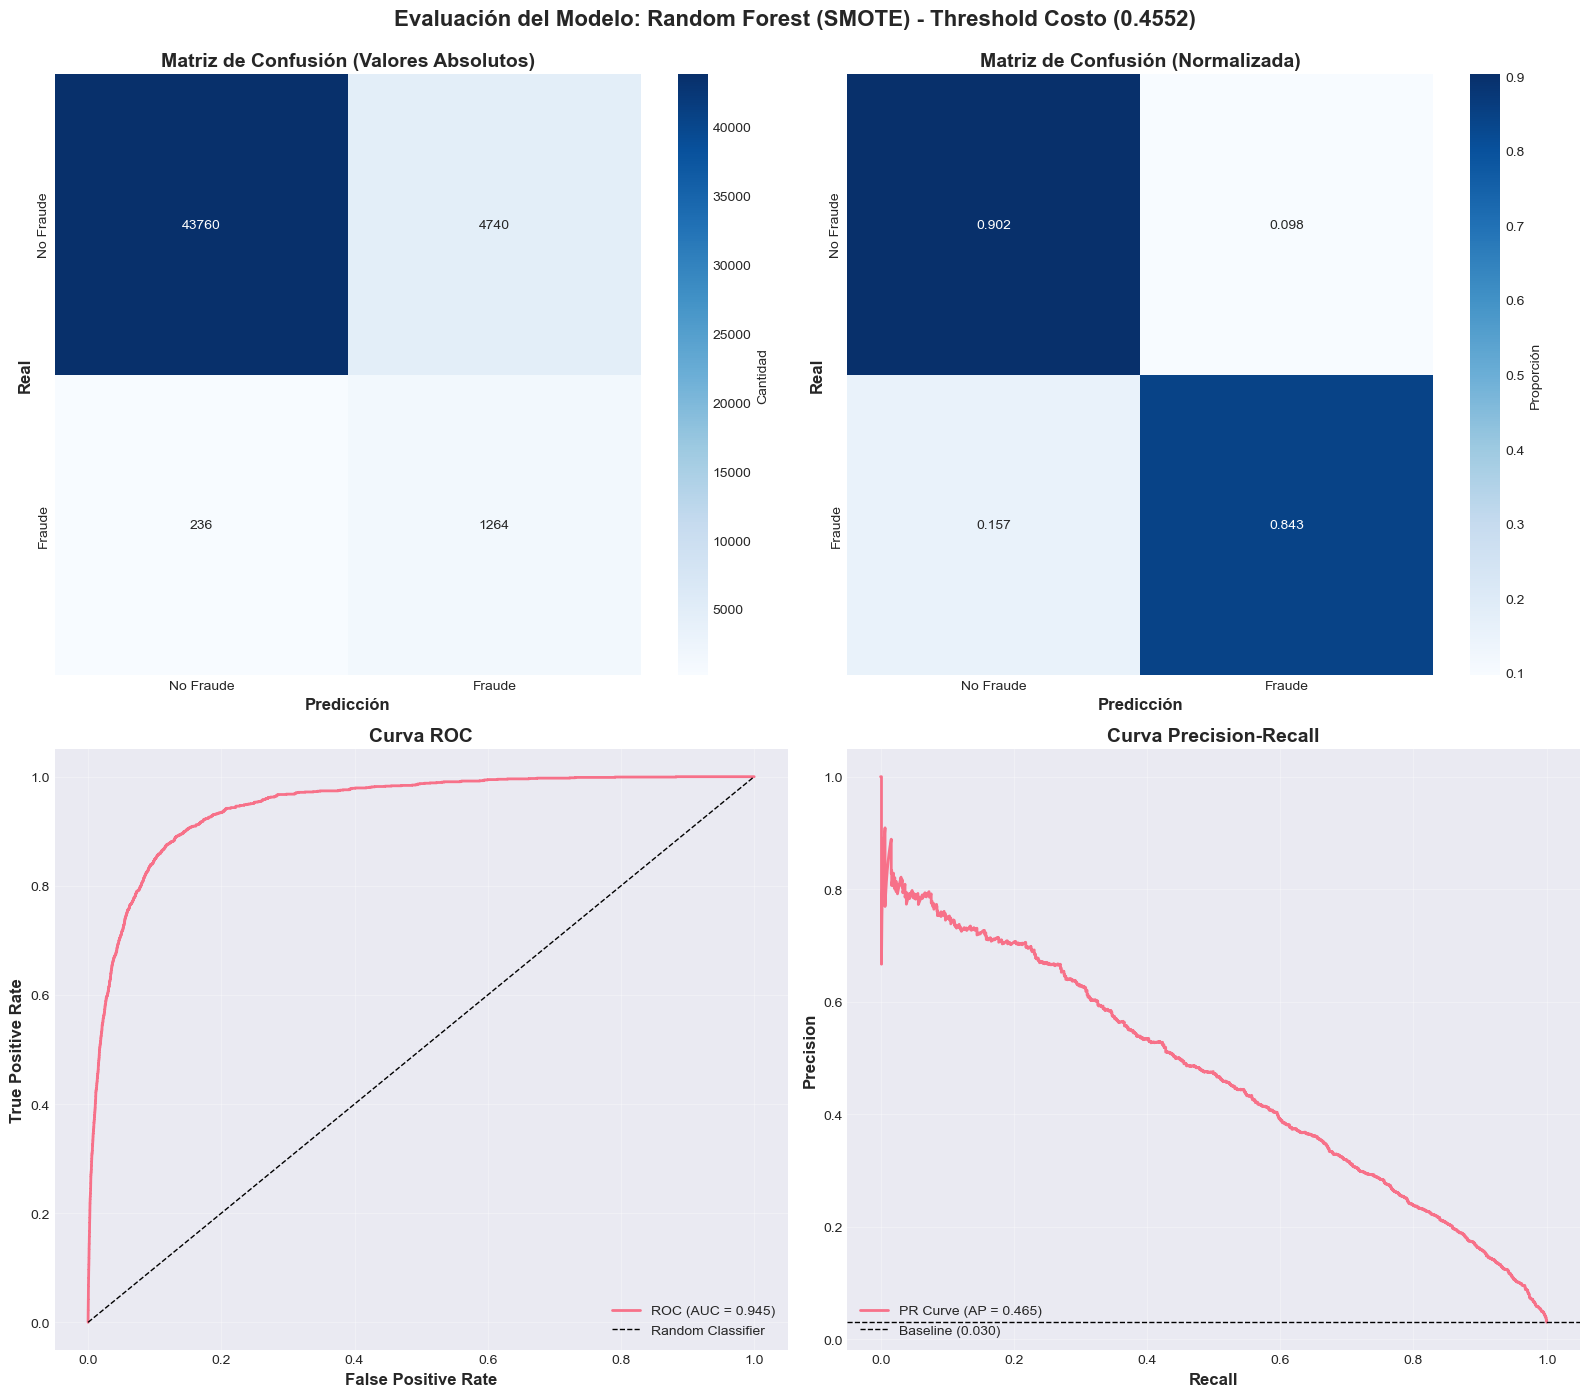

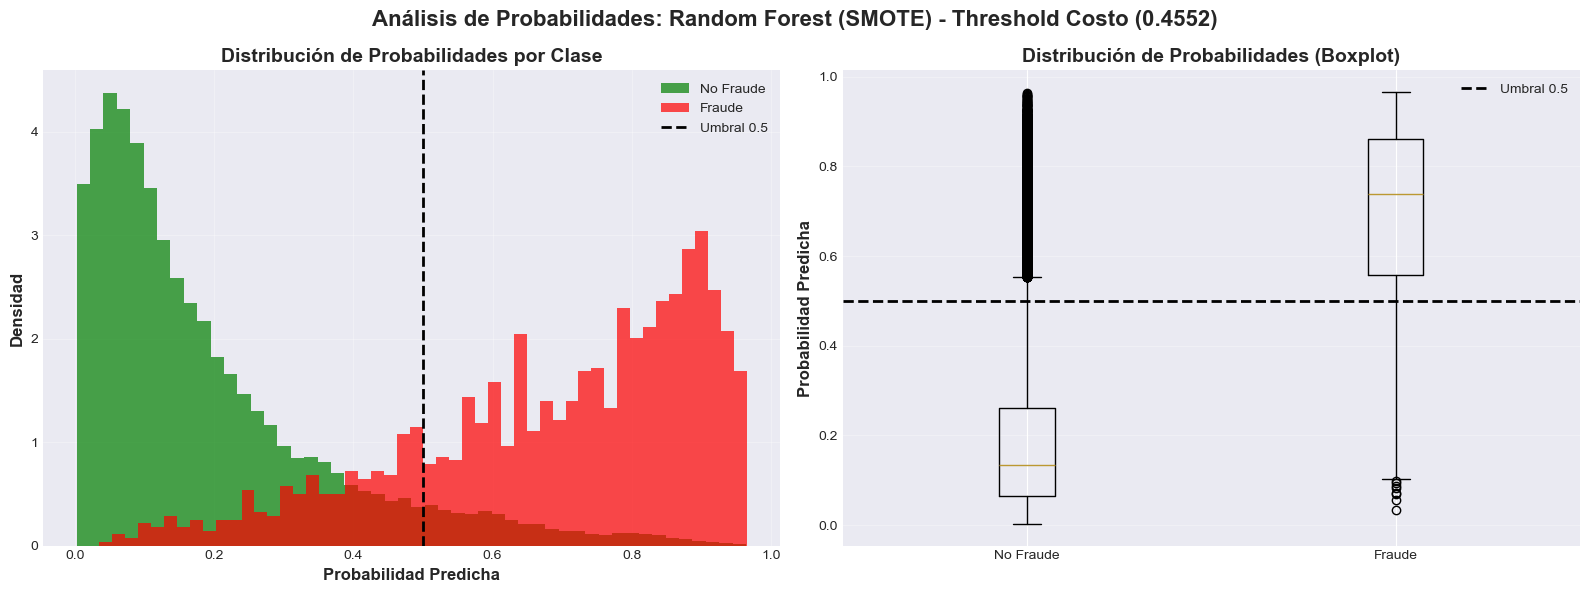


EVALUACIÓN CON THRESHOLD ÓPTIMO (F1 SCORE)
EVALUACIÓN DEL MODELO: Random Forest (SMOTE) - Threshold F1 (0.7082)

📌 Threshold usado: 0.7082

📊 DISTRIBUCIÓN DE CLASES:
   Clase 0 (No Fraude): 48,500 (97.00%)
   Clase 1 (Fraude):    1,500 (3.00%)
   Total:               50,000

🎯 MÉTRICAS PRINCIPALES:
   Accuracy:            0.9657
   F1 Score:            0.4882 ⭐
   Precision:           0.4415
   Recall (Sensitivity): 0.5460
   Specificity:         0.9786
   ROC AUC:             0.9451
   Average Precision:   0.4647

📈 MÉTRICAS ADICIONALES:
   Cohen's Kappa:       0.4707
   Matthews Corr Coef:  0.4735
   NPV:                 0.9859
   False Positive Rate: 0.0214

📊 RESUMEN DE MÉTRICAS CLAVE:
   Precision:          0.4415
   Recall:             0.5460
   F1 Score:           0.4882
   Cohen's Kappa:      0.4707
   Matthews Corr Coef: 0.4735
   Tasa positivos:     0.0371

💰 COSTO:
   Costo por 1000 registros: 1465.60
   (Costo FP: 5.0, Costo FN: 100.0)

🔢 MATRIZ DE CONFUSIÓN:
             

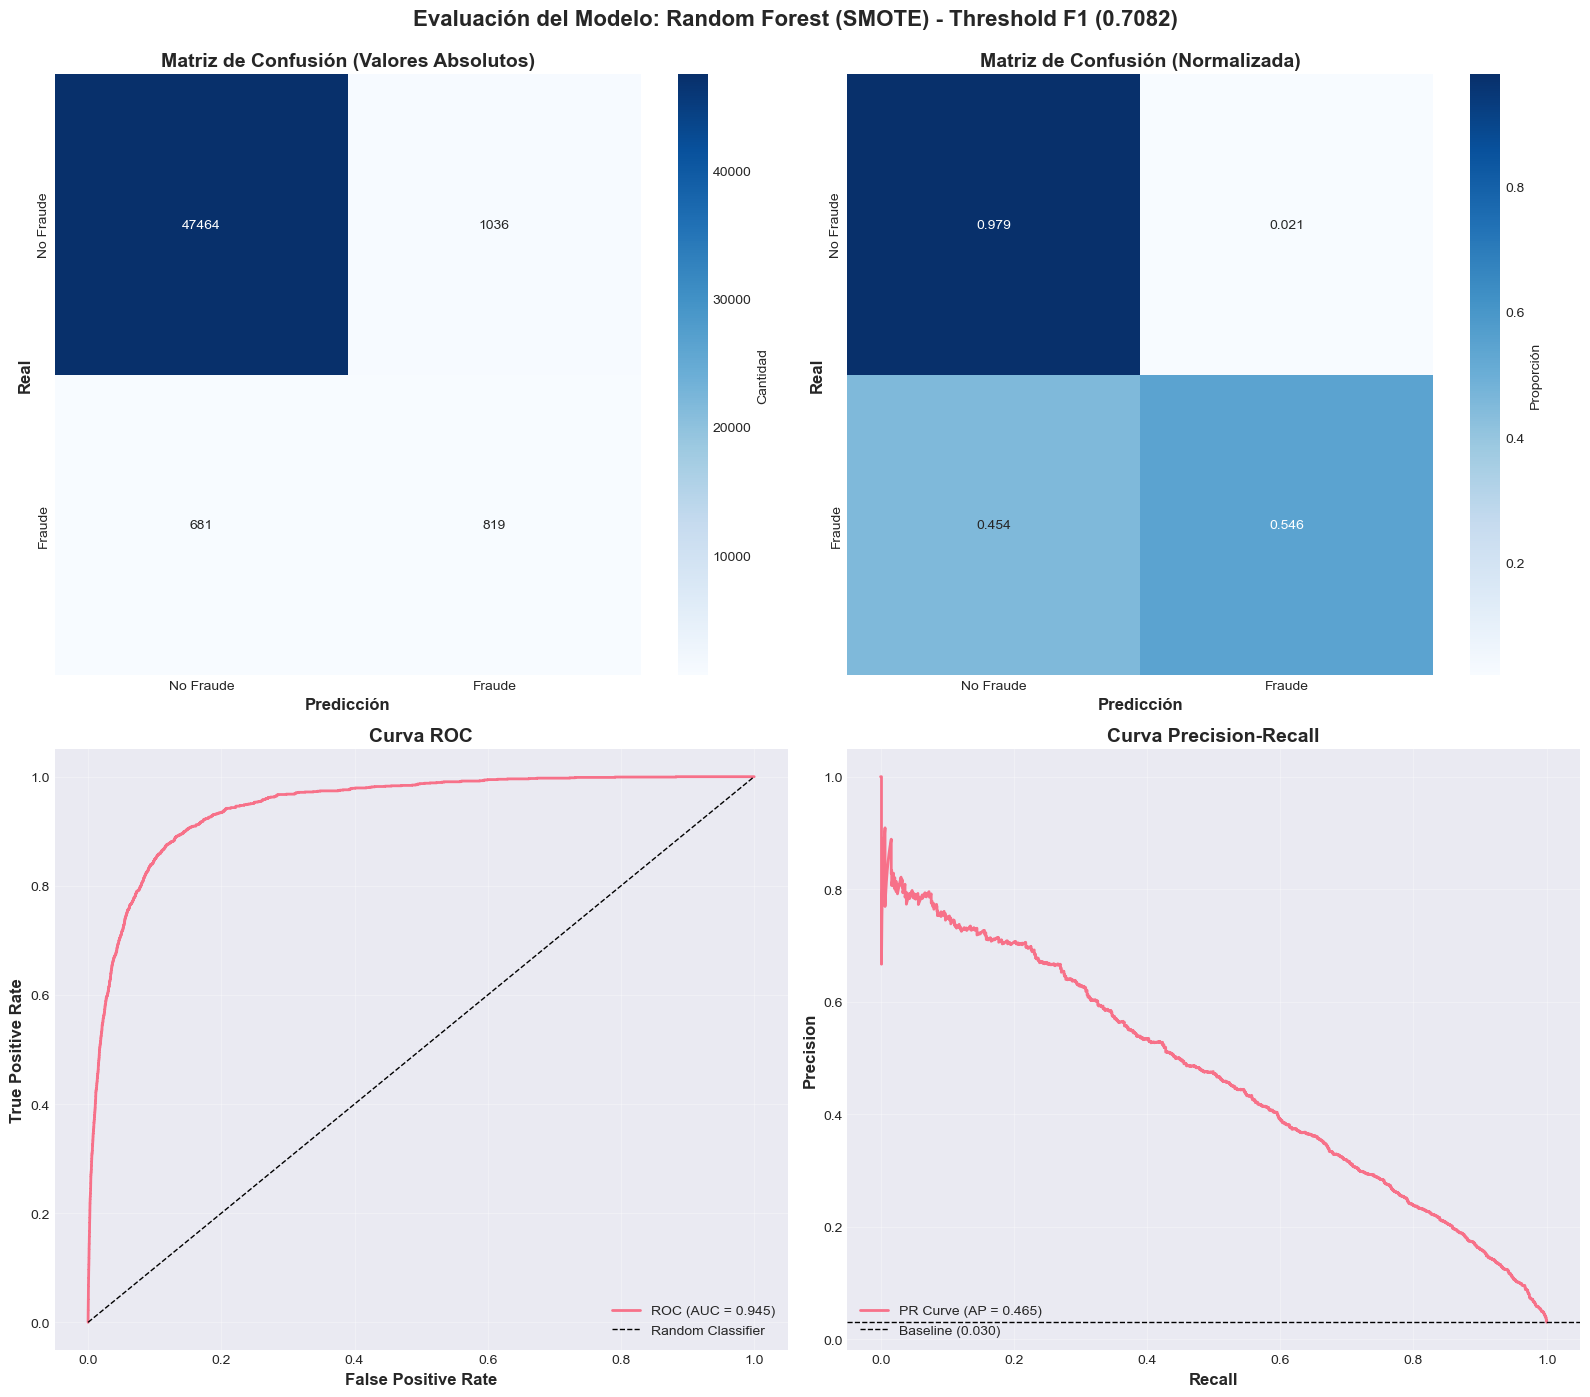

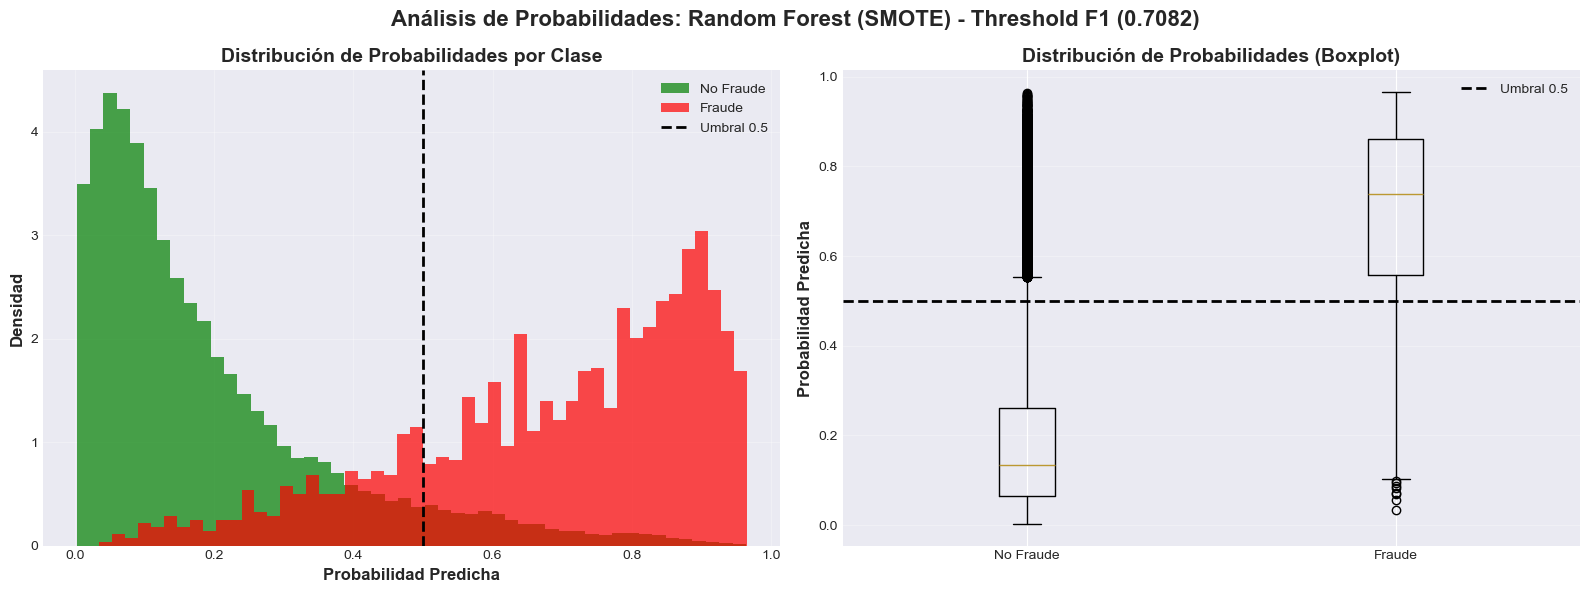

In [9]:
# ============================================================================
# PASO 3: EVALUAR MODELO CON AMBOS THRESHOLDS
# ============================================================================

print("=" * 80)
print("PASO 3: EVALUAR MODELO CON THRESHOLDS ÓPTIMOS")
print("=" * 80)

# Evaluar con threshold óptimo de costo
print("\n" + "=" * 80)
print("EVALUACIÓN CON THRESHOLD ÓPTIMO (COSTO)")
print("=" * 80)

metrics_costo = evaluate_model(
    y_true=y_test,
    y_proba=y_proba_test,
    threshold=threshold_optimo_costo,
    model_name=f"Random Forest (SMOTE) - Threshold Costo ({threshold_optimo_costo:.4f})",
    costo_fp=costo_fp,
    costo_fn=costo_fn
)

# Evaluar con threshold óptimo de F1
print("\n" + "=" * 80)
print("EVALUACIÓN CON THRESHOLD ÓPTIMO (F1 SCORE)")
print("=" * 80)

metrics_f1 = evaluate_model(
    y_true=y_test,
    y_proba=y_proba_test,
    threshold=threshold_optimo_f1,
    model_name=f"Random Forest (SMOTE) - Threshold F1 ({threshold_optimo_f1:.4f})",
    costo_fp=costo_fp,
    costo_fn=costo_fn
)


In [10]:
# ============================================================================
# IMPORTANCIA DE VARIABLES
# ============================================================================

print("=" * 80)
print("IMPORTANCIA DE VARIABLES (Ordenadas de mayor a menor)")
print("=" * 80)

# Obtener importancias del modelo final
importancias = rf_final.feature_importances_
variables = X_train.columns

# Crear DataFrame con importancias
df_importancias = pd.DataFrame({
    'Variable': variables,
    'Importancia': importancias
})

# Ordenar de mayor a menor
df_importancias = df_importancias.sort_values('Importancia', ascending=False).reset_index(drop=True)

# Agregar porcentaje acumulado
df_importancias['Importancia_%'] = df_importancias['Importancia'] * 100
df_importancias['Importancia_Acumulada_%'] = df_importancias['Importancia_%'].cumsum()

# Mostrar todas las variables
print(f"\n📊 Total de variables: {len(df_importancias)}")
print(f"\n{'Rank':<6} {'Variable':<40} {'Importancia':<15} {'%':<10} {'% Acum.':<10}")
print("-" * 85)

for idx, row in df_importancias.iterrows():
    print(f"{idx+1:<6} {row['Variable']:<40} {row['Importancia']:<15.6f} {row['Importancia_%']:<10.2f} {row['Importancia_Acumulada_%']:<10.2f}")

# Mostrar top 10
print("\n" + "=" * 80)
print("TOP 10 VARIABLES MÁS IMPORTANTES:")
print("=" * 80)
print(df_importancias.head(10)[['Variable', 'Importancia', 'Importancia_%']].to_string(index=False))

# Mostrar estadísticas
print("\n" + "=" * 80)
print("ESTADÍSTICAS DE IMPORTANCIA:")
print("=" * 80)
print(f"   - Importancia máxima: {df_importancias['Importancia'].max():.6f} ({df_importancias['Importancia'].max()*100:.2f}%)")
print(f"   - Importancia mínima: {df_importancias['Importancia'].min():.6f} ({df_importancias['Importancia'].min()*100:.2f}%)")
print(f"   - Importancia media:  {df_importancias['Importancia'].mean():.6f} ({df_importancias['Importancia'].mean()*100:.2f}%)")
print(f"   - Desviación estándar: {df_importancias['Importancia'].std():.6f} ({df_importancias['Importancia'].std()*100:.2f}%)")
print(f"\n   - Variables con >1% de importancia: {(df_importancias['Importancia_%'] > 1).sum()}")
print(f"   - Variables con >0.5% de importancia: {(df_importancias['Importancia_%'] > 0.5).sum()}")
print(f"   - Variables con <0.1% de importancia: {(df_importancias['Importancia_%'] < 0.1).sum()}")


IMPORTANCIA DE VARIABLES (Ordenadas de mayor a menor)

📊 Total de variables: 35

Rank   Variable                                 Importancia     %          % Acum.   
-------------------------------------------------------------------------------------
1      producto_freq                            0.296220        29.62      29.62     
2      categoria_id_target_enc                  0.193862        19.39      49.01     
3      o_is_NA                                  0.112794        11.28      60.29     
4      o_is_N                                   0.099084        9.91       70.20     
5      pais_target_enc                          0.035237        3.52       73.72     
6      a                                        0.032077        3.21       76.93     
7      pais_freq_enc                            0.029046        2.90       79.83     
8      producto_num_special_chars               0.025303        2.53       82.36     
9      n                                        0.022792   